In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import CONFIG, TORCH_GEN
from models.image_text_encoders import FLAIRAdapter
from data import image_UIDs, get_many_answer_gt, get_many_answer_pr, SegDataset, CLASS_MAP, NUM_CLASSES, crop_augment_preprocess_batch, flatten_class_splitted_answers
from color_map import apply_colormap, COLOR_MAP_DICT
from viz import overlay_attn_map, display_token_length_distr, display_prompt
from utils import batch_list, flatten_list

import torch
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as TF
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
from copy import deepcopy
from functools import partial
from pathlib import Path

In [3]:
# TODO use Git SubModules to integrate external repos in the project

# Attention Maps

In [4]:
idxs = list(range(0, 8))
batch_size = 4
viz_image_size = 300

In [5]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
answers_gt_texts = [answers_gt[i]['content'] for i in idxs]
len(answers_gt_texts)

8

In [6]:
img_idxs = image_UIDs[idxs]
viz_ds = SegDataset(img_idxs, resize_size=CONFIG['seg']['image_size'], class_map=CLASS_MAP)
len(viz_ds)

8

In [ ]:
augment_collate_fn = partial(crop_augment_preprocess_batch, crop_fn=T.CenterCrop(CONFIG['seg']['image_size']), augment_fn=None, preprocess_fn=None)
viz_dl = DataLoader(
    viz_ds,
    batch_size=batch_size,
    shuffle=False,
    generator=TORCH_GEN.clone_state(),
    collate_fn=augment_collate_fn,
)

answers_gt_texts = batch_list(answers_gt_texts, batch_size)

In [8]:
model = FLAIRAdapter()

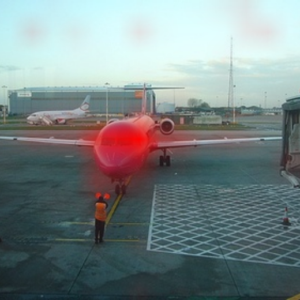

The ground truth AEROPLANE regions have been segmented in a coarser and incomplete way, especially regarding the wings, and two tiny AEROPLANE patches have been hallucinated on the right edge. The prediction mask for the ground truth PERSON region on the center-bottom-left is slightly more blob-like.


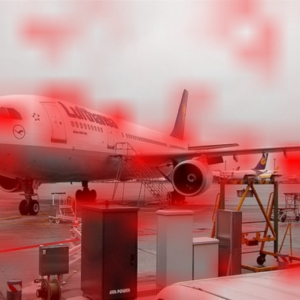

The ground truth AEROPLANE regions have been captured with irregular and erratic boundaries, while some AEROPLANE area has been hallucinated on the bottom of the scene.


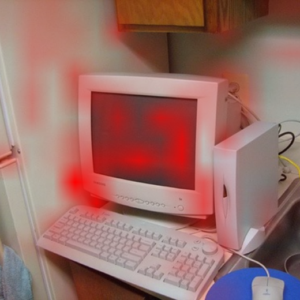

The ground truth MONITOR region on the center of the scene has been segmented with somewhat coarser and imperfect boundaries. The bottom and right boundaries of the region are especially flawed.


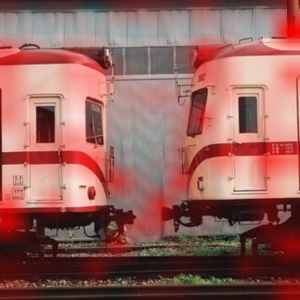

The prediction masks for the two ground truth TRAIN regions have some coarser boundaries, many details are lost.


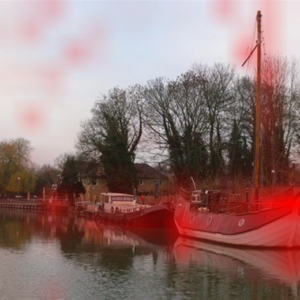

The prediction masks for the ground truth BOAT regions are coarser, imprecise and imperfect: the region on the right has been over-segmented a bit, while the region on the center has been slightly under-segmented and the vertical stripe on the right has mostly been missed.


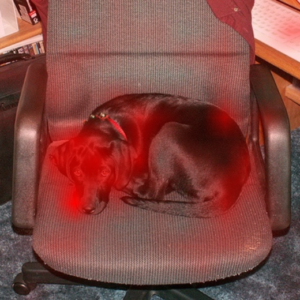

The prediction has many deviations from the ground truth and is overall much more chaotic. The prediction mask of the ground truth DOG region on the center is severily incomplete and irregular. The CHAIR region taking most of the scene has been segmented in a more irregular and erratic way, and the boundaries are inaccurate. Some area have been misclassified as SOFA instead of CHAIR on the top edge, and some has been misclassified as CHAIR instead of DOG in the center.


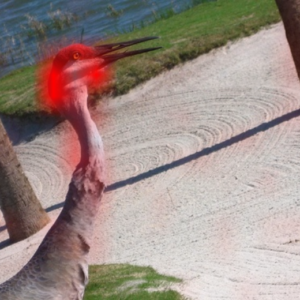

The prediction mask for the ground truth BIRD region misses the beak towards the top and has a couple of small holes in the center-bottom-left.


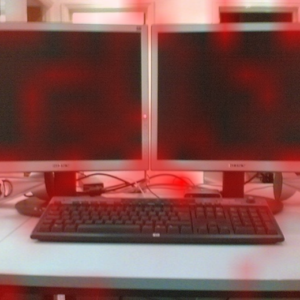

The prediction mask for the ground truth MONITOR regions are under-segmented towards the center-bottom (the monitor stands) and on the boundaries of the region towards the center-top and in the right corner. In general, the boundaries are a little less defined.


In [9]:
image_text_list = []

for step, (scs, gts) in enumerate(viz_dl):
    
    batch_images_tensor = torch.stack([model.preprocess_fn(to_pil_image(sc)) for sc in scs], dim=0).to(CONFIG['device']) # [B, 3, H_ite, W_ite]
    batch_answers_gt_texts = answers_gt_texts[step] # [B]
    texts_tensor = model.tokenizer(batch_answers_gt_texts).to(CONFIG['device']) # [B, context_length]
    
    attn_maps = model.get_attn_maps(batch_images_tensor, texts_tensor, upsample_size=CONFIG['seg']['image_size'], normalize=True) # [B, 1, H, W]

    ovr_imgs = [TF.resize(overlay_attn_map(scs[i], attn_maps[i]), viz_image_size)  for i in range(batch_size)]
    image_text_list.extend(zip(ovr_imgs, batch_answers_gt_texts))

display_prompt(flatten_list(image_text_list))

# Token Length Analysis

In [4]:
model = FLAIRAdapter()

**Ground truths** (non-splitted):

In [17]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
answers_gt_texts = [a['content'] for a in answers_gt]
tok_lengths = [model.count_tokens(t) for t in answers_gt_texts]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

80

critical_answers_amount=4


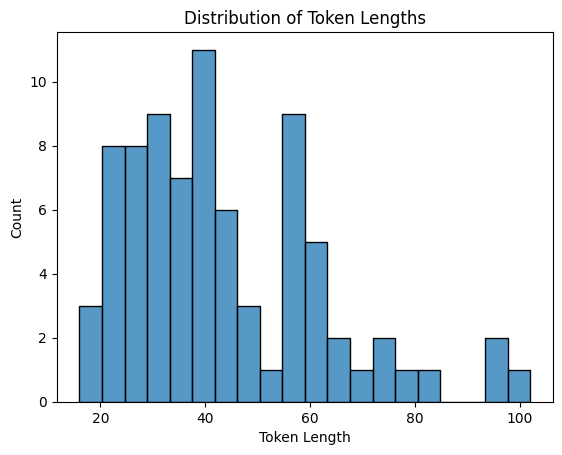

In [18]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Class-splitted predictions**:

In [19]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl")
answers_pr = flatten_class_splitted_answers(get_many_answer_pr(prs_path, return_state=False))
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

144

critical_answers_amount=2


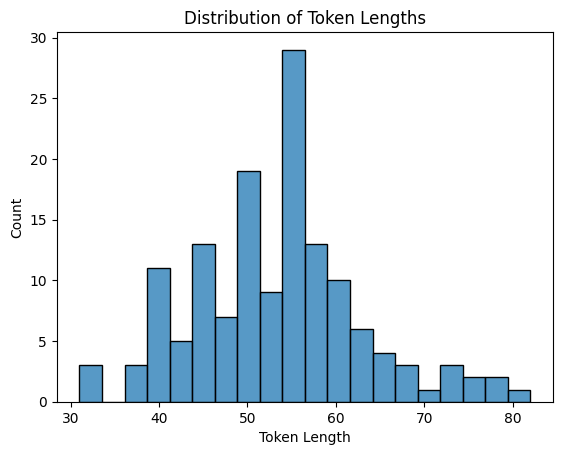

In [20]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Non-splitted predictions**:

In [21]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/non-splitted/answer_prs/gemini-2.0-flash/baseline/SepMasks_Ovr.jsonl")
answers_pr = get_many_answer_pr(prs_path, return_state=False)
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.tokenizer.context_length])
len(tok_lengths)

77

critical_answers_amount=3


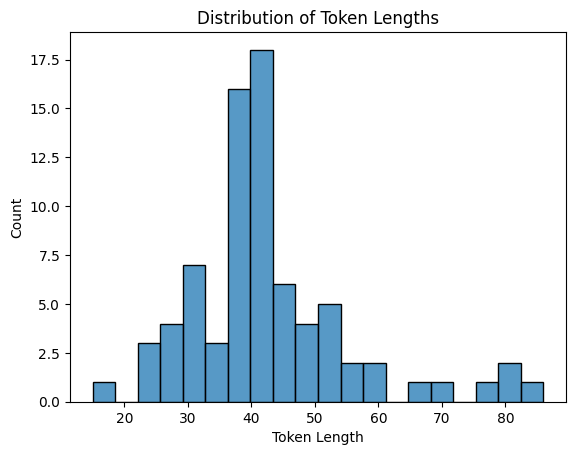

In [23]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

# Demo

In [4]:
model = FLAIRAdapter()

(453, 604)


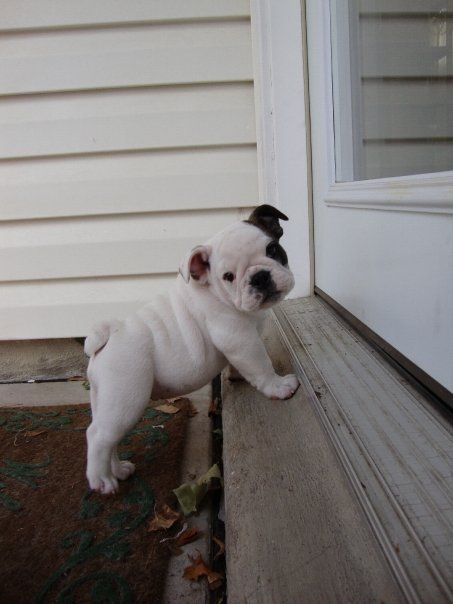

In [5]:
image = Image.open("/home/olivieri/exp/resources/puppy.jpg")
print(image.size)
image

In [11]:
image_tensor = model.preprocess_fn(image).to(CONFIG['device'])
images_tensor = torch.stack([image_tensor]*2, dim=0)
images_tensor.shape

torch.Size([2, 3, 224, 224])

In [12]:
texts_tensor = model.tokenizer([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "The white door and the window on the right side are closed.", # ground-truth caption
    "There are some leaves on the soil.", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
    "Dominating the scene is a white desk, positioned against a white brick wall" # non-ground-truth caption
]).to(CONFIG['device'])

In [13]:
texts_tensor = model.tokenizer([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
]).to(CONFIG['device'])

In [14]:
# with torch.no_grad(), torch.cuda.amp.autocast():
with torch.no_grad(), torch.amp.autocast(CONFIG['device']):
    flair_logits = model.model.get_logits(image=images_tensor, text=texts_tensor)
    clip_logits = model.model.get_logits_as_clip(image=images_tensor, text=texts_tensor)

    print("logits get using flair's way:", flair_logits) # [4.4062,  6.9531, -20.5000, -18.1719]
    print("logits get using clip's way:", clip_logits) # [12.4609, 15.6797, -3.8535, -0.2281]

logits get using flair's way: (tensor([[  4.3906, -20.5000],
        [  4.3906, -20.5000]], device='cuda:0', dtype=torch.float16), tensor([[  4.3906,   4.3906],
        [-20.5000, -20.5000]], device='cuda:0', dtype=torch.float16))
logits get using clip's way: (tensor([[12.4688, -3.8574],
        [12.4688, -3.8574]], device='cuda:0', dtype=torch.float16), tensor([[12.4688, 12.4688],
        [-3.8574, -3.8574]], device='cuda:0', dtype=torch.float16))


In [20]:
attn_maps = model.get_attn_maps(images_tensor, texts_tensor, upsample_size=image.size[::-1], normalize=True, broadcast=False)
attn_maps.shape

torch.Size([2, 1, 604, 453])

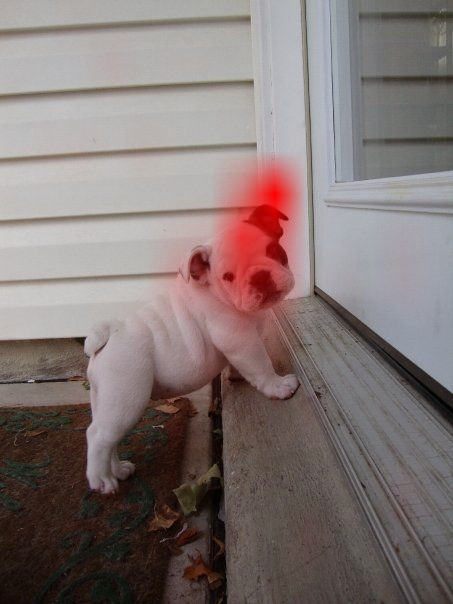

In [21]:
overlay_attn_map(image, attn_maps[0])